## Overivew

This is an example usage of image classification using the fastai library.

This notebook searches Bing for images of grizzly bears, black bears and teddy bears, downloads images and place them in folders accordingly. The notebook then loads the images and feeds them into a resnet18 model for training. Model metrics, such as confusion matrix and top losses are then displayed on the test set. Lastly, the model is exported to a pkl file.

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *
import urllib.request
import os

In [3]:
def search_images_bing(key, search_term, number_of_images=100):
    search_url = "https://api.bing.microsoft.com/v7.0/images/search/"
    headers = {"Ocp-Apim-Subscription-Key": key}
    params = {"q": search_term, "size": "medium", "count": number_of_images}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"][:]]
    return thumbnail_urls

def download_image(url, dest):
    name = random.randrange(1,100)
    fullname = dest
    urllib.request.urlretrieve(url, dest) 

You will need a Azure Bing API key in order to use Bing image search. Sign up for free tier [here](https://www.microsoft.com/en-us/bing/apis/bing-web-search-api).

In [4]:
#Set your key variable here, or use an environmental variable from your OS.
bing_api_key = os.environ["BING_API_KEY"]

In [5]:
results = search_images_bing(bing_api_key, search_term='grizzly bear')
image_urls = results

In [6]:
testing_dest = 'images/grizzly.jpg'
download_image(image_urls[0], testing_dest)

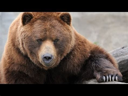

In [7]:
im = Image.open(testing_dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(bing_api_key, f'{o} bear')
        download_images(dest, urls=results)

In [10]:
fns = get_image_files(path)
fns

(#300) [Path(&#39;bears/black/00000096.jpg&#39;),Path(&#39;bears/black/00000080.jpg&#39;),Path(&#39;bears/black/00000076.jpg&#39;),Path(&#39;bears/black/00000057.jpg&#39;),Path(&#39;bears/black/00000041.jpg&#39;),Path(&#39;bears/black/00000000.jpg&#39;),Path(&#39;bears/black/00000021.jpg&#39;),Path(&#39;bears/black/00000072.jpg&#39;),Path(&#39;bears/black/00000025.jpg&#39;),Path(&#39;bears/black/00000065.jpg&#39;)...]

In [11]:
failed = verify_images(fns)
failed

&lt;IPython.core.display.HTML object&gt;

(#0) []

In [12]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [13]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = bears.dataloaders(path)

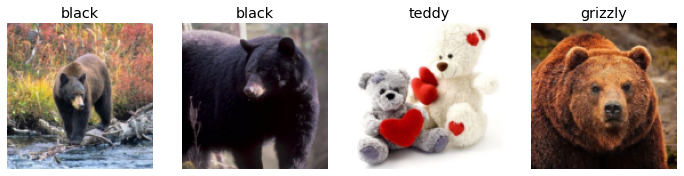

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

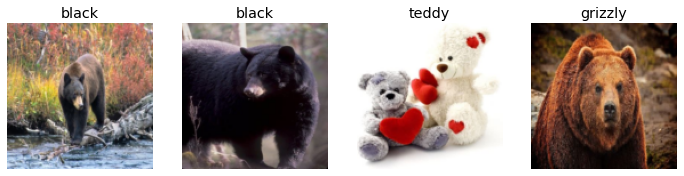

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

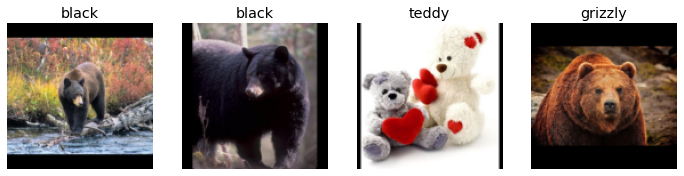

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

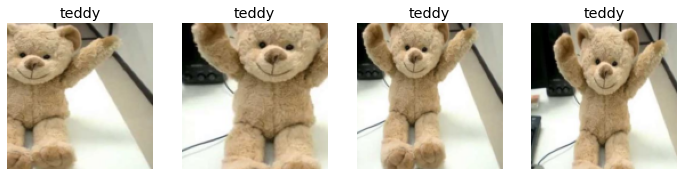

In [18]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

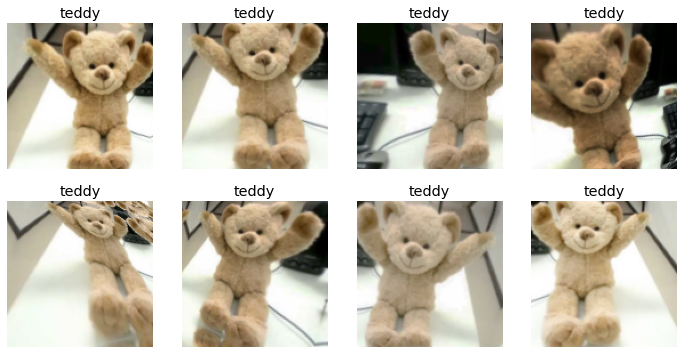

In [19]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training The Model

In [20]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

## Measuring the Model

&lt;IPython.core.display.HTML object&gt;

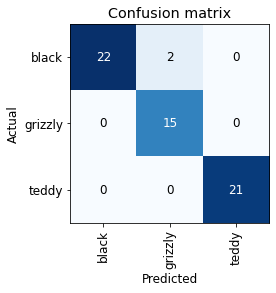

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

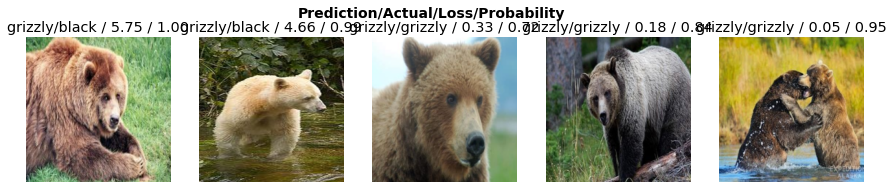

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

&lt;IPython.core.display.HTML object&gt;

&lt;IPython.core.display.HTML object&gt;

In [25]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Exporting the Model

In [26]:
learn.export()

In [27]:
learn_inf = load_learner('bear_model.pkl')

In [28]:
learn_inf.predict('images/grizzly.jpg')

&lt;IPython.core.display.HTML object&gt;

(&#39;grizzly&#39;, TensorImage(1), TensorImage([9.0746e-06, 9.9999e-01, 8.8976e-07]))

In [29]:
learn_inf.dls.vocab

[&#39;black&#39;, &#39;grizzly&#39;, &#39;teddy&#39;]